In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import json
import os

os.chdir("../")
from scripts import utils, alerceanomalies
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.svm import OneClassSVM
import distclassipy as dcpy
from distclassipy.anomaly import DistanceAnomaly
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, OutlierMixin
epsilon = np.finfo(np.float32).eps
with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

from IPython.core.display import HTML
from IPython.display import display

import squarify
set3colors = [matplotlib.colors.rgb2hex(x) for x in plt.cm.Set3.colors]
knowncolors = set3colors[:4]
unknowncolors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']
unknowncolors = set3colors[4:]+unknowncolors

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [2]:
models_to_test = {
    "iForest": IsolationForest( #using alerce anomaly params
        n_estimators=100,
        max_samples=256,
        contamination=0.001,
        random_state=seed_val
    ),
    "LOF": LocalOutlierFactor(
        n_neighbors=20, 
        novelty=True,  # IMPORTANT: Allows use on new data
        contamination='auto'
    ),
    
    "OC-SVM": OneClassSVM(
        kernel='rbf',
        nu=0.001
    ),

    "Autoencoder": alerceanomalies.AutoencoderAnomalyDetector(
        encoding_dim=32, # Can be tuned
        epochs=500,
        patience=15,
    ),

    "MCSVDD": alerceanomalies.ClassSVDDAnomalyDetector(
        z_dim=64,
        epochs=500,
        patience=15,
        lr=1e-4,
        verbose=False
    ),
        
    "DiMMAD (med-med)": DistanceAnomaly(
        cluster_agg='median',
        metric_agg='median',
        normalize_scores=True
    ),

    "DiMMAD (min-med)": DistanceAnomaly(
        cluster_agg='min',
        metric_agg='median',
        normalize_scores=True
    ),

}

In [3]:
features1 = pd.read_parquet("data/allfeatures.parquet")

features2 = pd.read_parquet("data/otherclassobjs_features.parquet")
features2.index.name = "snid"
features2cl = pd.read_parquet("data/otherclassobjs.parquet")
features2cl.index.name = "snid"
features2["class"] = features2cl["class"]
assert (features2.index == features2cl.index).all()
del(features2cl)

features3 = pd.read_parquet("data/otherclassobjs_features_23AUG.parquet")
features3.index.name = "snid"
features3cl = pd.read_parquet("data/otherclassobjs_23AUG.parquet")
features3cl.index.name = "snid"
features3["class"] = features3cl["class"]
assert (features3.index == features3cl.index).all()
del(features3cl)

commondat = pd.concat([features1,features2,features3])
commondat=commondat[~commondat.index.duplicated()]
del(features1, features2, features3)

assert (len(commondat.index) == len(commondat.index.unique()))

In [4]:
new_knowns = ['EB', 'DSCT', 'RRL', 'CEP']
new_unknowns = ['PISN-STELLA_HYDROGENIC', 'PISN-MOSFIT', 'uLens-Single_PyLIMA',
        'TDE', 'SNIcBL+HostXT_V19', 'KN_B19', 'uLens-Binary', 'SL-SNII',
        'SNIc-Templates', 'SLSN-I+host', 'SNIa-SALT3', 'SNIb-Templates',
        'SNII+HostXT_V19', 'SNIa-91bg', 'SL-SNIb', 'Mdwarf-flare', 'ILOT',
        'KN_K17', 'CART', 'SNIIb+HostXT_V19', 'SNIb+HostXT_V19', 'SL-SN1a',
        'SNII-NMF', 'SNIIn+HostXT_V19', 'SNII-Templates',
        'SNIc+HostXT_V19', 'SNIax', 'SNIIn-MOSFIT', 'uLens-Single-GenLens',
        'PISN-STELLA_HECORE', 'AGN', 'SLSN-I_no_host', 'SL-SNIc',
        'dwarf-nova']

features_to_use = [
    # 'SPM_A_g', 'SPM_gamma_g', 'SPM_beta_g', 'SPM_tau_rise_g', 'SPM_tau_fall_g',
    # 'SPM_A_r', 'SPM_gamma_r', 'SPM_beta_r', 'SPM_tau_rise_r', 'SPM_tau_fall_r'
    'SPM_A_g', 'SPM_gamma_g', 'SPM_beta_g', 'SPM_tau_rise_g', 'SPM_tau_fall_g',
    'SPM_A_r', 'SPM_gamma_r', 'SPM_beta_r', 'SPM_tau_rise_r', 'SPM_tau_fall_r',
    'SPM_A_i', 'SPM_gamma_i', 'SPM_beta_i', 'SPM_tau_rise_i', 'SPM_tau_fall_i',
    'SPM_A_z', 'SPM_gamma_z', 'SPM_beta_z', 'SPM_tau_rise_z', 'SPM_tau_fall_z',
    'SPM_A_Y', 'SPM_gamma_Y', 'SPM_beta_Y', 'SPM_tau_rise_Y', 'SPM_tau_fall_Y',
]



# Could use features we know are better for the 4 variable star classification
# but don't want to bias. additionally, the above features are simple and general
# and have very little NaNs.

In [5]:
len(commondat[commondat["class"].isin(new_knowns+new_unknowns)].loc[:,features_to_use].dropna())/len(commondat)

0.9943180678421697

In [6]:
ls = []
for col in commondat.columns:
    if col=="class":
        continue
    ls.append(len(commondat[col].dropna())/len(commondat))

In [7]:
np.median(ls)

np.float64(0.5395077330444725)

In [8]:
198271/199404

0.9943180678421697

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [10]:
all_classes = np.concatenate([new_knowns, new_unknowns])
full_df = commondat[commondat['class'].isin(all_classes)]
full_df = full_df.loc[:, list(features_to_use) + ["class"]].dropna(subset=features_to_use)
full_df = full_df[~full_df.index.duplicated(keep='first')]

# full_df['status'] = np.where(full_df['class'].isin(new_knowns), 'normal', 'anomalous')
# will use this for stratification

full_inlier_df = full_df[full_df["class"].isin(new_knowns)]
smallest_class_count = full_inlier_df["class"].value_counts().min()
full_outlier_df = full_df[full_df["class"].isin(new_unknowns)]

outlier_counts = full_outlier_df["class"].value_counts()
num_outlier_classes = len(outlier_counts)

In [11]:
# N_RUNS = 20

# # kf = KFold(n_splits=N_RUNS)

# all_run_results = []

# for i in tqdm(range(N_RUNS), desc="Running Experiments"):
#     current_seed = seed_val+i
    
#     # Balance inlier classes
#     keep_indices = full_inlier_df.groupby("class").sample(smallest_class_count, random_state=current_seed).index
#     inlier_df=full_inlier_df[full_inlier_df.index.isin(keep_indices)]
#     thrown_inlier_df = inlier_df[~inlier_df.index.isin(keep_indices)]
    
#     # Split balanced inliers into train/test
#     inlier_train_df, inlier_test_df = train_test_split(
#         inlier_df, test_size=0.5, random_state=current_seed,
#         stratify=inlier_df['class'],
#     )    
    
#     tot_inliers_in_test = inlier_test_df["class"].value_counts().sum()
#     frac_outliers_in_test = 0.9
#     tot_outliers_in_test = int(frac_outliers_in_test * tot_inliers_in_test)

#     samples_to_take = {}
#     active_classes = list(outlier_counts.index)
#     remaining_to_sample = tot_outliers_in_test
#     available_counts = outlier_counts.copy()
    
#     while True:
#         if not active_classes:
#             break
    
#         ideal_samples_per_class = remaining_to_sample / len(active_classes)
        
#         # Find classes that have fewer members than the ideal number
#         small_classes = [
#             c for c in active_classes if available_counts[c] < ideal_samples_per_class
#         ]
    
#         if not small_classes:
#             # No more small classes, proceed to final distribution
#             break
    
#         # For each small class, take all available members
#         for class_name in small_classes:
#             num_to_take = available_counts[class_name]
#             samples_to_take[class_name] = num_to_take
            
#             remaining_to_sample -= num_to_take
#             active_classes.remove(class_name)
    
#     # Distribute the rest of the samples among the larger classes
#     if active_classes:
#         base_samples = remaining_to_sample // len(active_classes)
#         remainder = remaining_to_sample % len(active_classes)
    
#         for i, class_name in enumerate(active_classes):
#             if i < remainder:
#                 samples_to_take[class_name] = base_samples + 1
#             else:
#                 samples_to_take[class_name] = base_samples
    
#     # Perform the actual sampling
#     sampled_dfs = []
#     for class_name, n_samples in samples_to_take.items():
#         class_df = full_outlier_df[full_outlier_df['class'] == class_name].sample(n=n_samples, random_state=current_seed)
#         sampled_dfs.append(class_df)
    
#     # Combine all the sampled data into a final DataFrame
#     final_sampled_df = pd.concat(sampled_dfs)

#     X_train_df = inlier_train_df[features_to_use]
#     y_train_df = inlier_train_df['class']

#     X_test_df = pd.concat([inlier_test_df[features_to_use], final_sampled_df[features_to_use]]).sample(frac=1, random_state=current_seed)
#     y_test_df = pd.concat([inlier_test_df['class'], final_sampled_df['class']]).loc[X_test_df.index]

#     results_df = pd.DataFrame(index=X_test_df.index)
#     results_df['class'] = y_test_df
#     mask = results_df['class'].isin(new_knowns)
#     results_df['status'] = np.where(mask, 'normal', 'anomalous')

#     for model_name, model_template in models_to_test.items():
#         model = clone(model_template)

#         if 'random_state' in model.get_params():
#             model.set_params(random_state=current_seed)
        
#         if "DistClassiPy" in model_name or "ClassSVDD" in model_name:
#             model.fit(X_train_df.to_numpy(), y_train_df.to_numpy())
#         else:
#             model.fit(X_train_df.to_numpy())
            
#         scores = model.decision_function(X_test_df.to_numpy())
#         if model_name in ["IsolationForest", "LocalOutlierFactor", "OneClassSVM"]:
#             scores = -scores

#         results_df[f'score_{model_name}'] = scores
        
#     all_run_results.append(results_df)

In [12]:
# import pickle
# with open("06. paper neurips mlps/results/exp1_results.pkl","wb") as fp:
#     pickle.dump(all_run_results, fp)

In [13]:
import pickle
with open("06. paper neurips mlps/results/exp1_results.pkl","rb") as fp:
    all_run_results=pickle.load(fp)

In [14]:
from pathlib import Path
import matplotlib as mpl
import matplotlib.font_manager as font_manager

fpath = Path(mpl.get_data_path(), "/Users/sidchaini/Downloads/computer-modern/cmunrm.ttf")

font_manager.fontManager.addfont(fpath)

prop = font_manager.FontProperties(fname=fpath)
font_name = prop.get_name()
# Set the default font family to your custom font
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

In [15]:
def analysis_with_errors(all_fold_results, budget=300, metric='purity'):
    for model_name in tqdm(models_to_test.keys(), desc="Analyzing Models", leave=False):
        print("*"*10, model_name, "*"*10)
        fold_curves = []
        max_anom_in_folds = [fold_res['status'].value_counts().get('anomalous', 0) for fold_res in all_fold_results]
        
        budget = min(budget, min(max_anom_in_folds))
        top_ns = np.arange(1, budget + 1)
        
        for fold_res in all_fold_results:
            curve = []
            topresults_df = fold_res.sort_values(by=f"score_{model_name}", ascending=False)
            # print(topresults_df["status"].value_counts(normalize=True))
            
            for i in top_ns:
                top_candidates = topresults_df.head(i)
                
                if metric == 'purity':
                    valcounts = top_candidates['status'].value_counts(normalize=True)
                    value = valcounts.get("anomalous", 0)
                elif metric == 'diversity':
                    anomalous_found = top_candidates[top_candidates["status"] == "anomalous"]
                    value = len(anomalous_found["class"].unique())
                else:
                    raise ValueError("Metric must be 'purity' or 'diversity'")
                curve.append(value)
            fold_curves.append(curve)
        
        # Convert list of curves to a 2D numpy array for easy stats
        fold_curves_arr = np.array(fold_curves)
        
        mean_curve = np.mean(fold_curves_arr, axis=0)
        std_curve = np.std(fold_curves_arr, axis=0)
        
        # Plotting
        lw = 3.25 if "dimmad".lower() in model_name.lower() else 1.75
        label_name = model_name.replace(r"DiMMAD", r"$DiMMAD$")
        p = plt.plot(top_ns, mean_curve, label=model_name, linewidth=lw, color=mycolors[model_name], linestyle=mylinestyles[model_name])
        plt.fill_between(top_ns, 
                         np.clip(mean_curve - 0.5*std_curve,a_min=0, a_max=1), 
                         np.clip(mean_curve + 0.5*std_curve,a_min=0, a_max=1), 
                         color=p[0].get_color(), alpha=0.1)

    if metric == 'purity':
        plt.ylabel("Mean Purity", fontsize=16)
    elif metric == 'diversity':
        plt.ylabel("New Classes Discovered", fontsize=16)
        
    plt.xlabel("Follow-up Budget (No. of sources)", fontsize=16)
    plt.gca().tick_params(axis='both', which='major', labelsize=16)
    plt.gca().tick_params(axis='both', which='minor', labelsize=12)
    legend = plt.legend(loc='lower right', fontsize=12, framealpha=1)
    
    
    for text in legend.get_texts():
        if "dimmad" in text.get_text().lower():
            text.set_fontweight('bold')

    # plt.grid(False)
    plt.grid(True, which="both", linestyle=":", linewidth=0.5)
    # plt.title("EXP1: Novel Phenomena Hunt ELAsTiCC")
    return plt.gcf()

In [16]:
mycolors = {
 'DiMMAD (min-med)': "#FFB000",
 'DiMMAD (med-med)': "#785EF0",
 'iForest': "#648FFF",
 'LOF': "#FE6100",
 'OC-SVM': "#DC267F",
 'Autoencoder': "#5F3331",
 'MCSVDD': "#6BC59D"
}

mylinestyles = {
 'DiMMAD (min-med)': 'solid',
 'DiMMAD (med-med)': 'solid',
 'iForest': 'dotted',
 'LOF': 'dashdot',
 'OC-SVM': 'dashed',
 'Autoencoder': (0, (3, 1, 1, 1)),
 'MCSVDD': (0, (5, 1))
}

newnames = {
 'score_DistClassiPy (min-median)': 'score_DiMMAD (min-med)',
 'score_DistClassiPy (median-median)': 'score_DiMMAD (med-med)',
 'score_IsolationForest': 'score_iForest',
 'score_LocalOutlierFactor': 'score_LOF',
 'score_OneClassSVM': 'score_OC-SVM',
 'score_Autoencoder': 'score_Autoencoder',
 'score_ClassSVDD': 'score_MCSVDD',
}

In [17]:
all_run_results2 = []
for ar in all_run_results:
    all_run_results2.append(ar.rename(columns=newnames))
del(all_run_results)
all_run_results = all_run_results2
del(all_run_results2)

In [18]:
snid = 31293294
all_files = [
        pd.read_parquet("data/otherclassobjs.parquet"),
        pd.read_parquet("data/otherclassobjs_23AUG.parquet"),
        pd.read_parquet("data/Cepheid.parquet"),
        pd.read_parquet("data/plotdf.parquet"),
    ]

for i in range(4):
    try:
        all_files[i]=all_files[i].set_index("SNID")
    except Exception:
        pass

In [19]:
all_files = pd.concat(all_files)

In [64]:
def plot_lc(lcdf, snid):
    chosen_df = lcdf.loc[snid]
    cur_cl = chosen_df["class"]
    cols = ["MJD", "FLUXCAL", "FLUXCALERR", "BAND", "PHOTFLAG", "ZEROPT"]
    dat = []
    for col in cols:
        if col in cols:
            dat.append(chosen_df.loc[col])
    dat = np.array(dat).T
    lc = pd.DataFrame(data=dat,columns=cols).sort_values(by="MJD")

    plt.figure(figsize=(4, 4))
    for band in "ugrizY":
        lc_band = lc[lc["BAND"] == band]
        plt.errorbar(
            x=lc_band["MJD"],
            y=lc_band["FLUXCAL"],
            yerr=np.clip(lc_band["FLUXCALERR"], a_min=None, a_max=lc_band["FLUXCAL"].max()),
            fmt="o",
            label=f"{band}",
        )
    plt.xlabel("Time (in days)")
    plt.ylabel("Brightness (flux)")
    ax = plt.gca()
    x = ax.get_xticks()
    ax.set_xticks(x[1:-1:1])
    ax.tick_params(axis="both", which="major")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ax.legend(bbox_to_anchor=(1.14, 0.55),ncol=1,loc="lower center")
    plt.title(f"OID {snid} ({cur_cl})")
    # plt.xlim(peak_mjd - 40, peak_mjd + 90)
    # plt.grid()
    # plt.savefig("lc.png", bbox_inches="tight", dpi=300)
    return plt.gcf()

In [126]:
ALL = pd.concat(all_run_results)

In [141]:
ALL = all_run_results[7]

In [174]:
if_ids = ALL.sort_values(by="score_iForest", ascending=False).iloc[:5]["class"]
if_ids

snid
43717842      CEP
97153243     DSCT
155481312     CEP
73065172     DSCT
135511375     CEP
Name: class, dtype: object

In [150]:
dimmad_ids = ALL.sort_values(by="score_DiMMAD (min-med)", ascending=False).iloc[:5]["class"]
dimmad_ids

snid
121796206                    KN_K17
21479478                   SNII-NMF
34953173                         EB
99789488                         EB
66627671     PISN-STELLA_HYDROGENIC
Name: class, dtype: object

In [149]:
mcsvdd_ids = ALL.sort_values(by="score_MCSVDD", ascending=False).iloc[:5]["class"]
mcsvdd_ids

snid
155481312           CEP
97153243           DSCT
23353678     dwarf-nova
36049081           DSCT
1067946             CEP
Name: class, dtype: object

In [148]:
ocsvm_ids = ALL.sort_values(by="score_OC-SVM", ascending=False).iloc[:5]["class"]
ocsvm_ids

snid
155481312     CEP
97153243     DSCT
3486588      DSCT
37970946     DSCT
53523206      CEP
Name: class, dtype: object

In [175]:
loc_ids = ALL.sort_values(by="score_LOF", ascending=False).iloc[:5]["class"]
loc_ids

snid
43520093     ILOT
61879393       EB
27421621      AGN
155481312     CEP
22568201     DSCT
Name: class, dtype: object

In [155]:
cls = {43717842: "CEP",
97153243: "DSCT",
155481312: "CEP",
73065172: "DSCT",
135511375: "CEP",
121796206: "KN_K17",
21479478: "SNII-NMF",
34953173: "EB",
99789488: "EB",
66627671: "PISN-STELLA_HYDROGENIC",
155481312: "CEP",
97153243: "DSCT",
23353678: "dwarf-nova",
36049081: "DSCT",
1067946: "CEP",
155481312: "CEP",
97153243: "DSCT",
3486588: "DSCT",
37970946: "DSCT",
53523206: "CEP",
43520093: "ILOT",
61879393: "EB",
27421621: "AGN",
155481312: "CEP",
22568201: "DSCT"}

In [164]:
def plot_lc(lcdf, snid):
    chosen_df = lcdf.loc[snid]
    cur_cl = cls[snid]
    cols = ["MJD", "FLUXCAL", "FLUXCALERR", "BAND", "PHOTFLAG", "ZEROPT"]
    dat = []
    for col in cols:
        if col in cols:
            dat.append(chosen_df.loc[col])
    dat = np.array(dat).T
    lc = pd.DataFrame(data=dat,columns=cols).sort_values(by="MJD")

    plt.figure(figsize=(4, 4))
    for band in "ugrizY":
        lc_band = lc[lc["BAND"] == band]
        plt.errorbar(
            x=lc_band["MJD"],
            y=lc_band["FLUXCAL"],
            yerr=lc_band["FLUXCALERR"],
            fmt="o",
            label=f"{band}",
        )
    plt.xlabel("Time (in days)")
    plt.ylabel("Brightness (flux)")
    ax = plt.gca()
    x = ax.get_xticks()
    ax.set_xticks(x[1:-1:1])
    ax.tick_params(axis="both", which="major")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ax.legend(bbox_to_anchor=(1.14, 0.55),ncol=1,loc="lower center")
    plt.title(f"OID {snid} ({cur_cl})")
    # plt.xlim(peak_mjd - 40, peak_mjd + 90)
    # plt.grid()
    # plt.savefig("lc.png", bbox_inches="tight", dpi=300)
    return plt.gcf()

In [165]:
import pandas as pd
df = pd.read_parquet("06. paper neurips mlps/anomLCs.parquet")

class                      dwarf-nova
status                      anomalous
score_iForest               -0.110715
score_LOF                    2.992716
score_OC-SVM                 0.216794
score_Autoencoder         131008648.0
score_MCSVDD               322.288666
score_DiMMAD (med-med)       0.445634
score_DiMMAD (min-med)       0.511121
Name: 23353678, dtype: object

class                     PISN-STELLA_HYDROGENIC
status                                 anomalous
score_iForest                          -0.190386
score_LOF                              -0.410704
score_OC-SVM                           -0.000064
score_Autoencoder                    1739.944214
score_MCSVDD                            3.377469
score_DiMMAD (med-med)                  0.891942
score_DiMMAD (min-med)                  0.946441
Name: 66627671, dtype: object


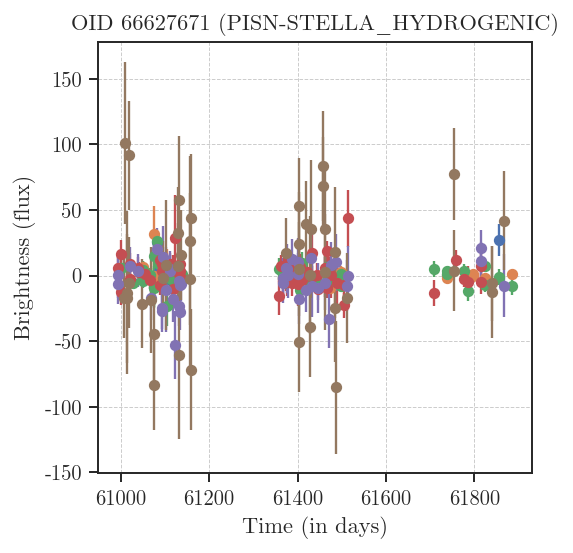

class                            DSCT
status                         normal
score_iForest               -0.035777
score_LOF                    2.617101
score_OC-SVM                 0.246582
score_Autoencoder         326025888.0
score_MCSVDD               101.680153
score_DiMMAD (med-med)       0.473784
score_DiMMAD (min-med)       0.408356
Name: 3486588, dtype: object


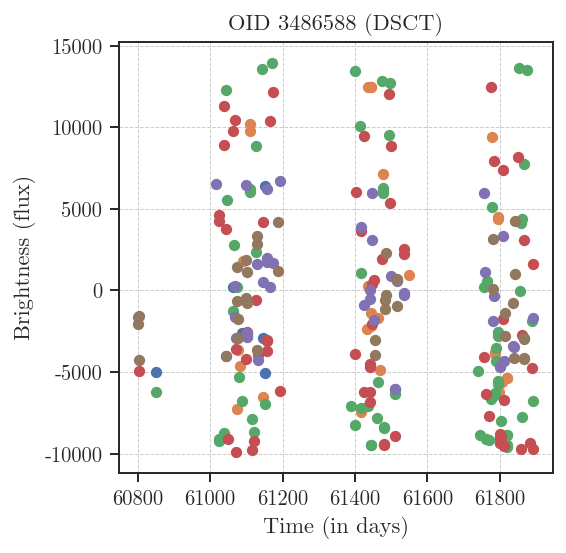

class                             DSCT
status                          normal
score_iForest                 -0.30432
score_LOF                    60.124764
score_OC-SVM                 -0.000524
score_Autoencoder         189713.78125
score_MCSVDD                  3.283543
score_DiMMAD (med-med)        0.086928
score_DiMMAD (min-med)         0.11996
Name: 22568201, dtype: object


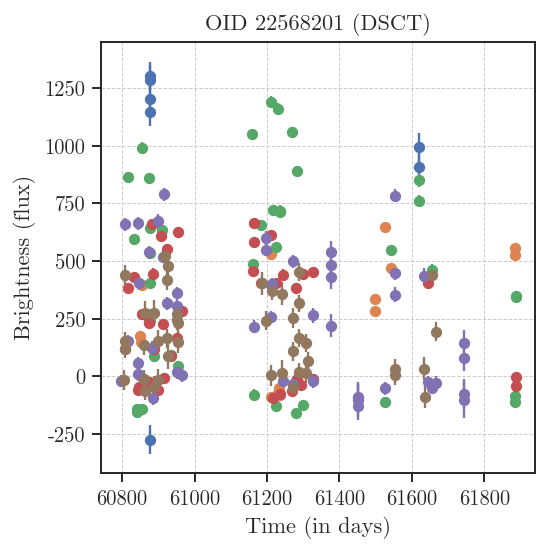

class                            DSCT
status                         normal
score_iForest               -0.146429
score_LOF                    4.987229
score_OC-SVM                 0.135453
score_Autoencoder         849069760.0
score_MCSVDD               237.999084
score_DiMMAD (med-med)       0.296517
score_DiMMAD (min-med)         0.2493
Name: 36049081, dtype: object


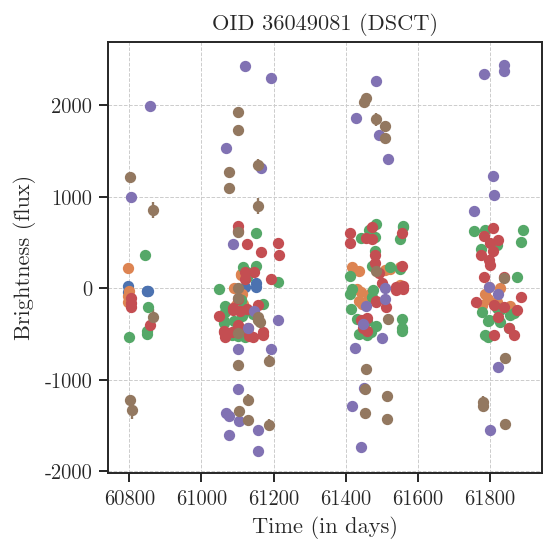

class                            DSCT
status                         normal
score_iForest               -0.028984
score_LOF                    2.489288
score_OC-SVM                 0.246109
score_Autoencoder         309555328.0
score_MCSVDD               139.295807
score_DiMMAD (med-med)       0.440801
score_DiMMAD (min-med)        0.45265
Name: 37970946, dtype: object


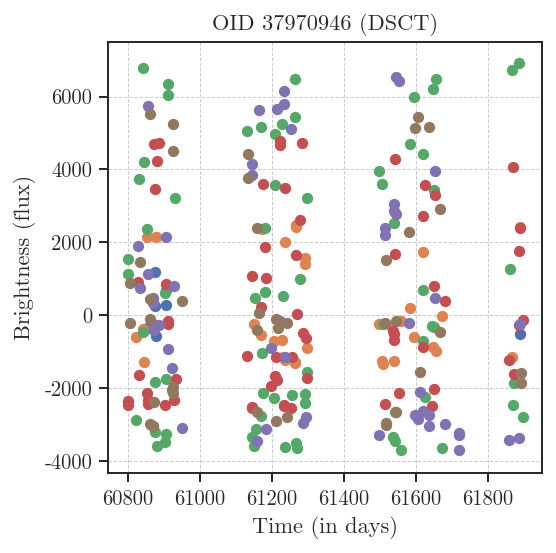

class                           DSCT
status                        normal
score_iForest               0.012575
score_LOF                   0.780696
score_OC-SVM               -0.004003
score_Autoencoder         42660872.0
score_MCSVDD                4.722117
score_DiMMAD (med-med)       0.65239
score_DiMMAD (min-med)      0.696509
Name: 73065172, dtype: object


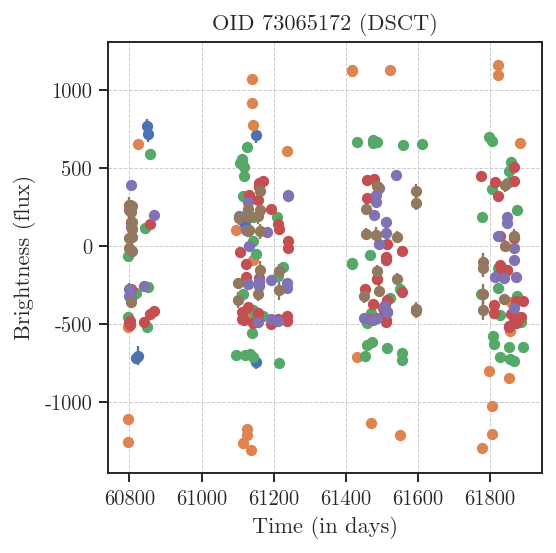

class                             DSCT
status                          normal
score_iForest                 0.024213
score_LOF                    11.112538
score_OC-SVM                  0.248538
score_Autoencoder         3035788288.0
score_MCSVDD               1263.032227
score_DiMMAD (med-med)        0.445254
score_DiMMAD (min-med)          0.5273
Name: 97153243, dtype: object


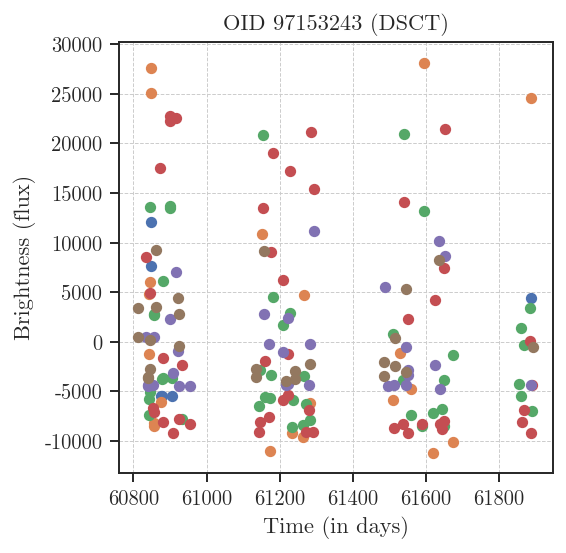

class                             ILOT
status                       anomalous
score_iForest                -0.310967
score_LOF                    96.890123
score_OC-SVM                   -0.0005
score_Autoencoder         182640.90625
score_MCSVDD                  5.092752
score_DiMMAD (med-med)        0.096398
score_DiMMAD (min-med)        0.126356
Name: 43520093, dtype: object


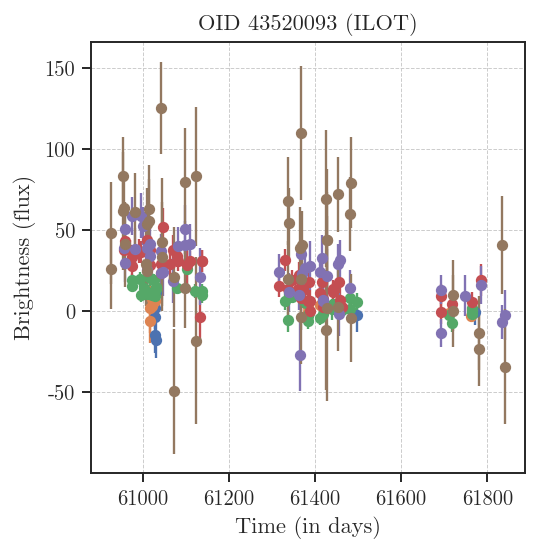

class                        KN_K17
status                    anomalous
score_iForest             -0.107498
score_LOF                  0.173002
score_OC-SVM              -0.000117
score_Autoencoder         30101.875
score_MCSVDD               2.483919
score_DiMMAD (med-med)     0.946223
score_DiMMAD (min-med)     0.969907
Name: 121796206, dtype: object


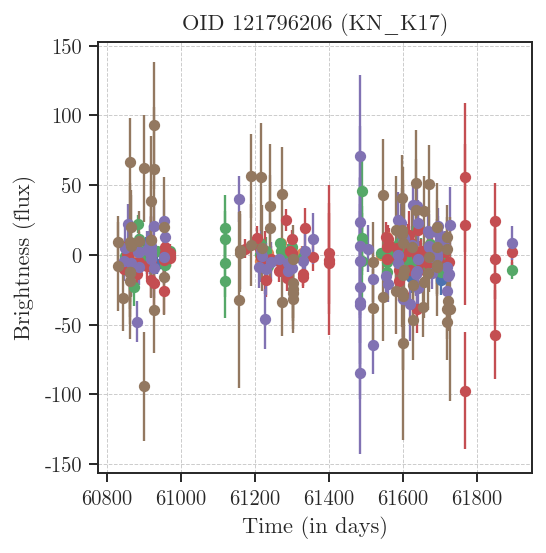

class                      SNII-NMF
status                    anomalous
score_iForest             -0.051223
score_LOF                  0.566439
score_OC-SVM               0.000339
score_Autoencoder          70343.25
score_MCSVDD               3.202674
score_DiMMAD (med-med)     0.961062
score_DiMMAD (min-med)     0.967888
Name: 21479478, dtype: object


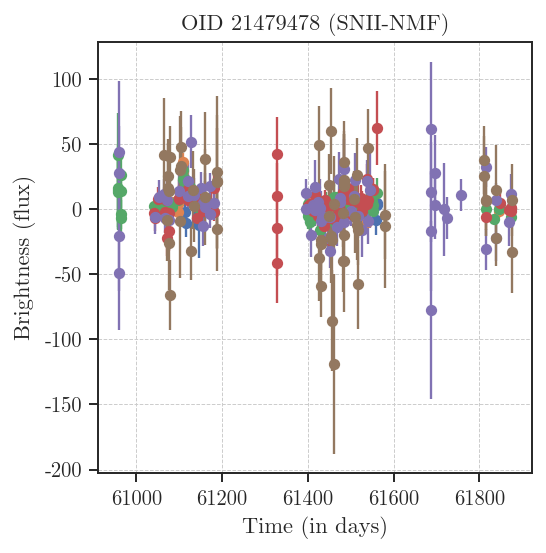

class                            CEP
status                        normal
score_iForest              -0.013802
score_LOF                   0.460253
score_OC-SVM                0.092342
score_Autoencoder         51571364.0
score_MCSVDD              148.043625
score_DiMMAD (med-med)       0.42059
score_DiMMAD (min-med)      0.489272
Name: 1067946, dtype: object


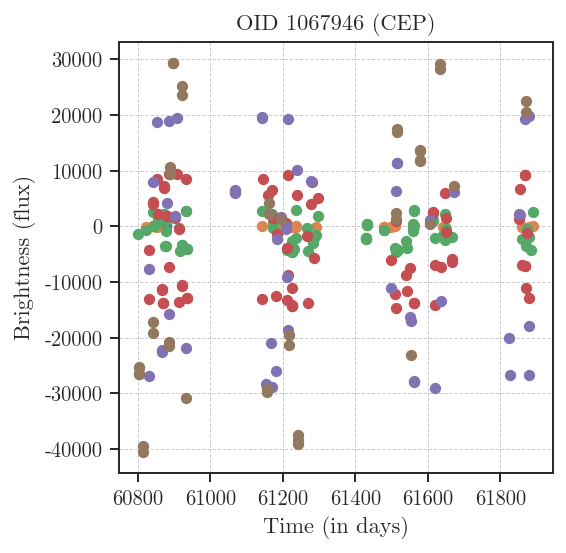

class                            CEP
status                        normal
score_iForest               0.028582
score_LOF                   0.120732
score_OC-SVM                0.035632
score_Autoencoder         59730896.0
score_MCSVDD               24.814878
score_DiMMAD (med-med)      0.641933
score_DiMMAD (min-med)      0.568951
Name: 43717842, dtype: object


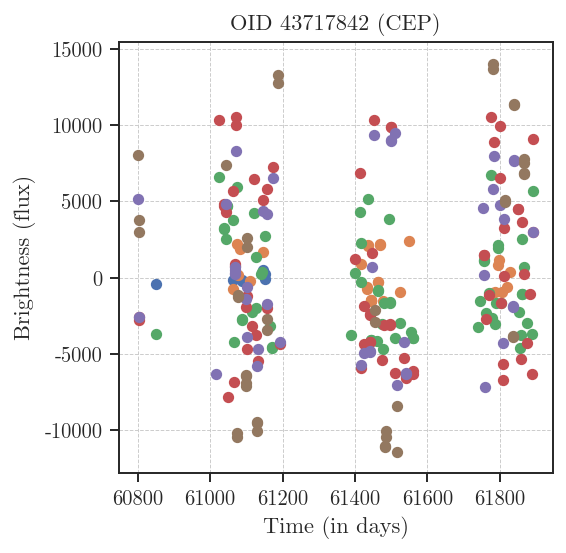

class                             CEP
status                         normal
score_iForest               -0.012353
score_LOF                    1.893797
score_OC-SVM                  0.23687
score_Autoencoder         232318656.0
score_MCSVDD                52.604832
score_DiMMAD (med-med)       0.524748
score_DiMMAD (min-med)       0.537599
Name: 53523206, dtype: object


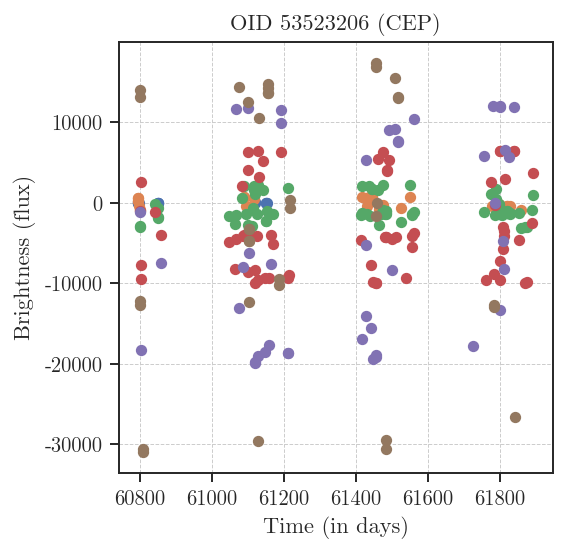

class                            CEP
status                        normal
score_iForest               0.007042
score_LOF                   0.758912
score_OC-SVM               -0.001564
score_Autoencoder         15093307.0
score_MCSVDD               38.973602
score_DiMMAD (med-med)      0.655784
score_DiMMAD (min-med)      0.646645
Name: 135511375, dtype: object


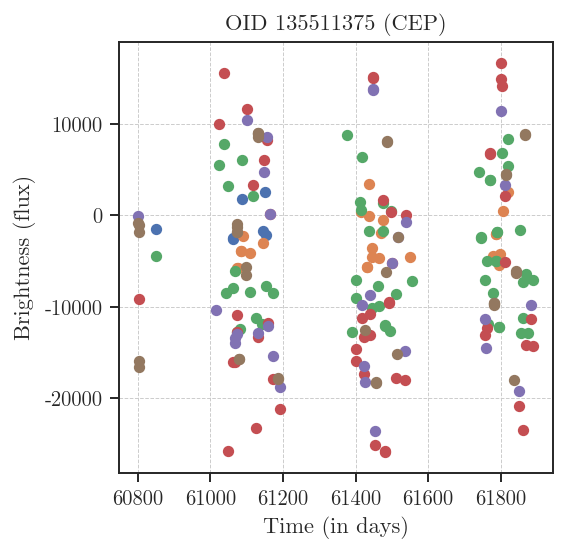

class                                CEP
status                            normal
score_iForest                    0.01445
score_LOF                      68.659795
score_OC-SVM                    0.248538
score_Autoencoder         138371284992.0
score_MCSVDD               121785.007812
score_DiMMAD (med-med)               1.0
score_DiMMAD (min-med)          0.891748
Name: 155481312, dtype: object


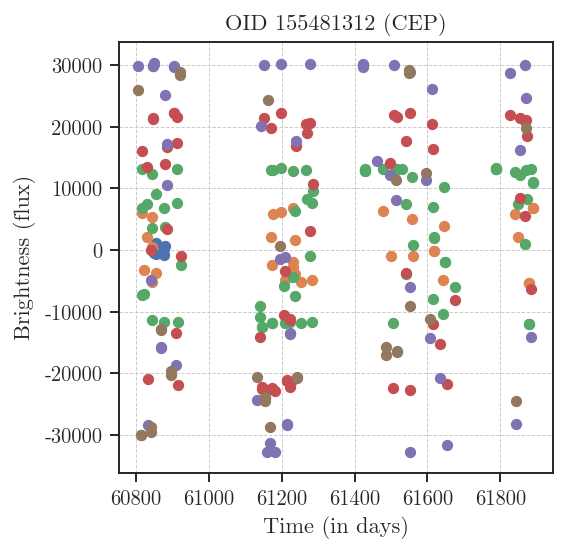

class                              EB
status                         normal
score_iForest               -0.197358
score_LOF                   -0.387649
score_OC-SVM                 0.000036
score_Autoencoder         2284.364014
score_MCSVDD                 3.305982
score_DiMMAD (med-med)       0.937852
score_DiMMAD (min-med)       0.950972
Name: 99789488, dtype: object


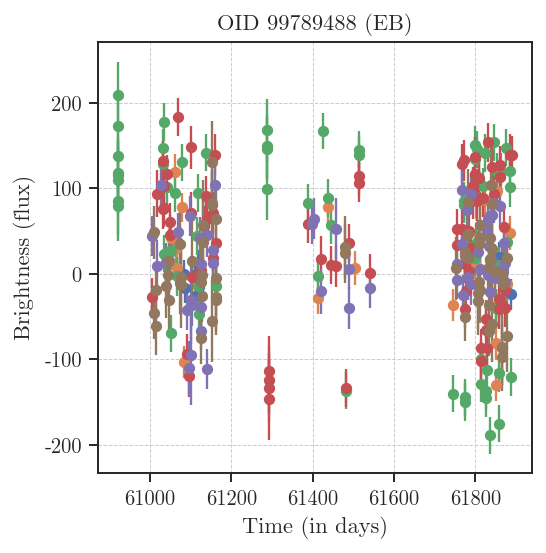

class                              AGN
status                       anomalous
score_iForest                -0.290806
score_LOF                    69.318088
score_OC-SVM                 -0.000517
score_Autoencoder         170426.96875
score_MCSVDD                  6.023758
score_DiMMAD (med-med)        0.114133
score_DiMMAD (min-med)        0.150587
Name: 27421621, dtype: object


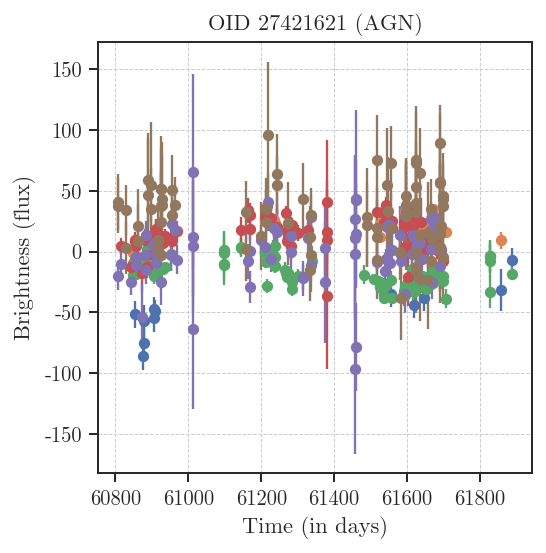

class                               EB
status                          normal
score_iForest                -0.110584
score_LOF                     0.126972
score_OC-SVM                 -0.000396
score_Autoencoder         25032.119141
score_MCSVDD                   2.44629
score_DiMMAD (med-med)        0.893182
score_DiMMAD (min-med)        0.963161
Name: 34953173, dtype: object


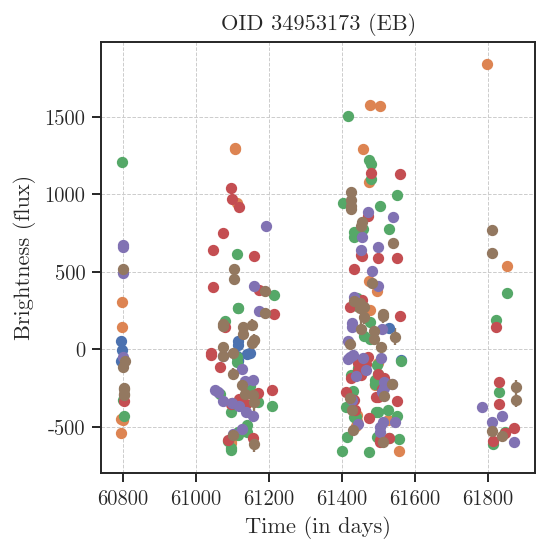

class                              EB
status                         normal
score_iForest               -0.298698
score_LOF                   83.877741
score_OC-SVM                -0.000384
score_Autoencoder         183623.1875
score_MCSVDD                 2.517401
score_DiMMAD (med-med)        0.09868
score_DiMMAD (min-med)       0.129618
Name: 61879393, dtype: object


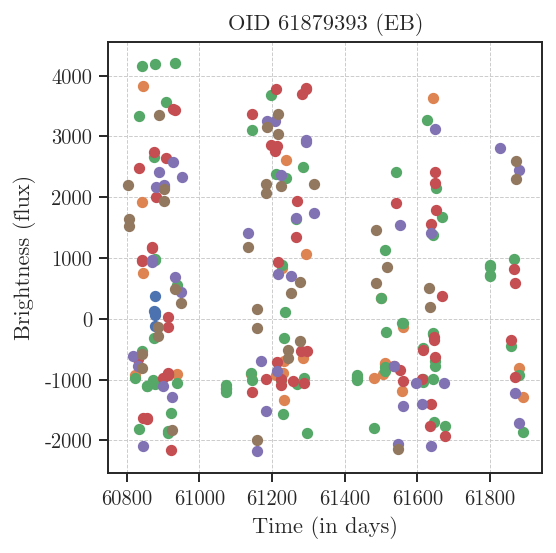

class                      dwarf-nova
status                      anomalous
score_iForest               -0.110715
score_LOF                    2.992716
score_OC-SVM                 0.216794
score_Autoencoder         131008648.0
score_MCSVDD               322.288666
score_DiMMAD (med-med)       0.445634
score_DiMMAD (min-med)       0.511121
Name: 23353678, dtype: object


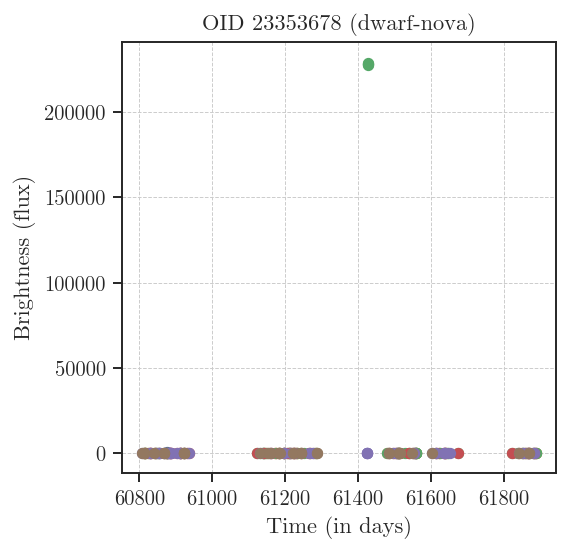

In [172]:
for snid in df.index:
    print(ALL.loc[snid])
    plot_lc(df, snid)
    plt.show()

In [22]:
topsnids = []
colname = "iForest"
for i in range(20):
    topsnids.append(all_run_results[i].sort_values(by=f"score_{colname}",ascending=False).index[0])
    print(all_run_results[i].sort_values(by=f"score_{colname}",ascending=False)["status"].iloc[0])

normal
normal
normal
normal
normal
normal
anomalous
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal
normal


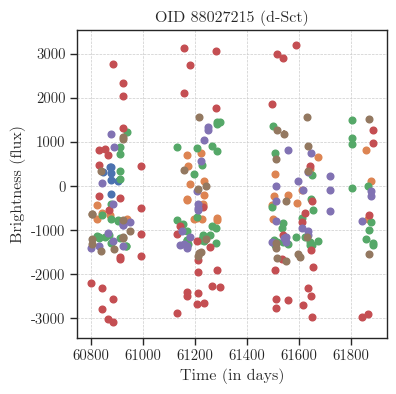

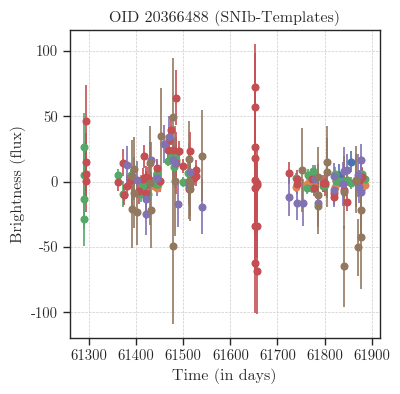

In [108]:
for snid in topsnids:
    try:
        if snid in all_files.index:
            plot_lc(all_files, snid)
            plt.show()
    except Exception as e:
        continue

In [109]:
snid = 39800396
plot_lc(all_files, snid)
plt.show()

KeyError: 'MJD'

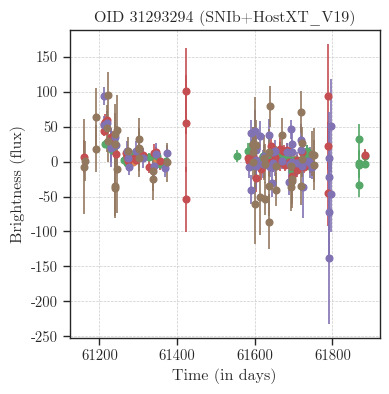


--- Purity vs. Budget Plot ---


Analyzing Models:   0%|          | 0/7 [00:00<?, ?it/s]

********** iForest **********
********** LOF **********
********** OC-SVM **********
********** Autoencoder **********
********** MCSVDD **********
********** DiMMAD (med-med) **********
********** DiMMAD (min-med) **********


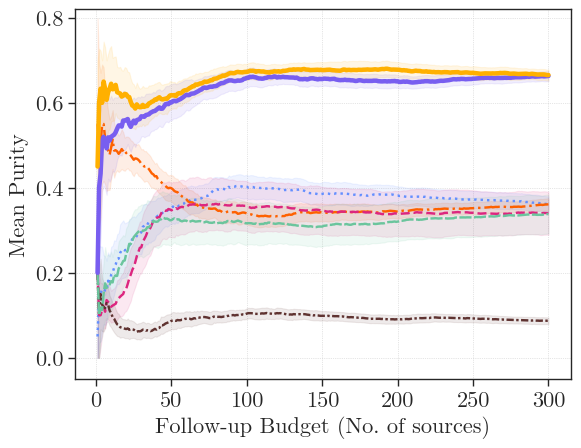


--- Diversity of Discovery Plot ---


Analyzing Models:   0%|          | 0/7 [00:00<?, ?it/s]

********** iForest **********
********** LOF **********
********** OC-SVM **********
********** Autoencoder **********
********** MCSVDD **********
********** DiMMAD (med-med) **********
********** DiMMAD (min-med) **********


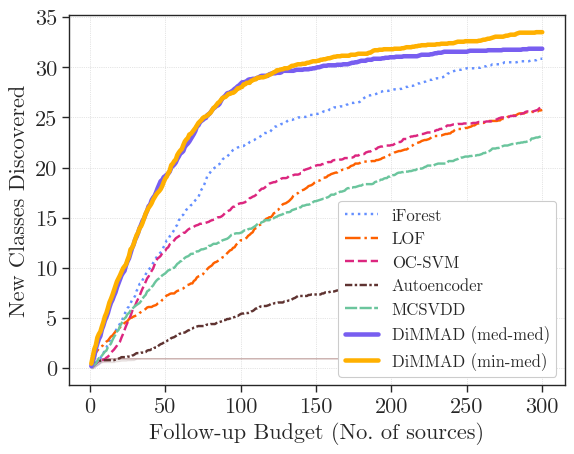

In [20]:
print("\n--- Purity vs. Budget Plot ---")
fig = analysis_with_errors(all_run_results, budget=300, metric='purity')
plt.ylim(-0.05,0.82)
plt.gca().get_legend().remove()
plt.savefig("06. paper neurips mlps/plots/Fig1a.pdf", bbox_inches="tight")
plt.show()

print("\n--- Diversity of Discovery Plot ---")
fig = analysis_with_errors(all_run_results, budget=300, metric='diversity')
plt.savefig("06. paper neurips mlps/plots/Fig1b.pdf", bbox_inches="tight")
plt.show()


--- Purity vs. Budget Plot ---


Analyzing Models:   0%|          | 0/7 [00:00<?, ?it/s]

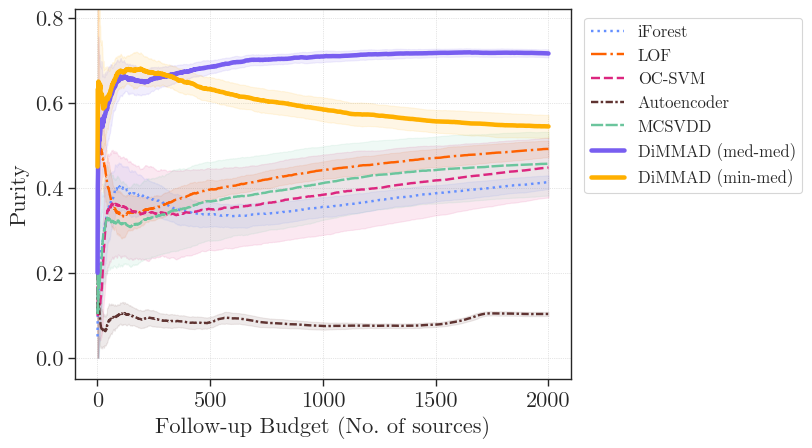


--- Diversity of Discovery Plot ---


Analyzing Models:   0%|          | 0/7 [00:00<?, ?it/s]

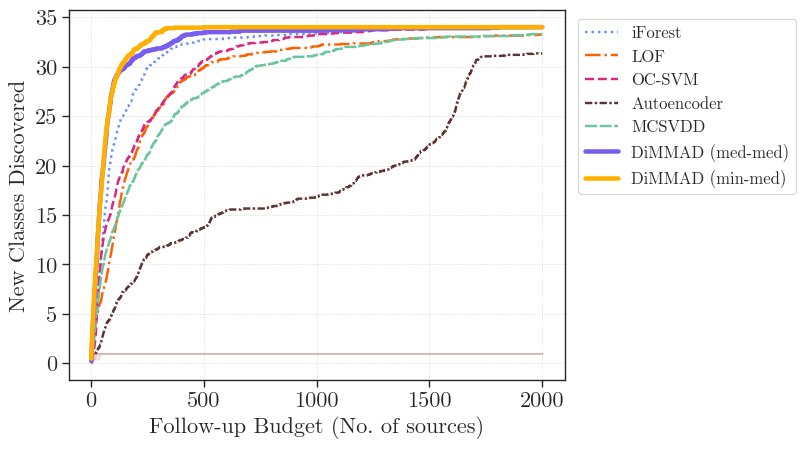

In [36]:
print("\n--- Purity vs. Budget Plot ---")
fig = analysis_with_errors(all_run_results, budget=2000, metric='purity')
plt.ylim(-0.05,0.82)
plt.show()

print("\n--- Diversity of Discovery Plot ---")
fig = analysis_with_errors(all_run_results, budget=2000, metric='diversity')
plt.show()



--- Purity vs. Budget Plot ---


Analyzing Models:   0%|          | 0/7 [00:00<?, ?it/s]

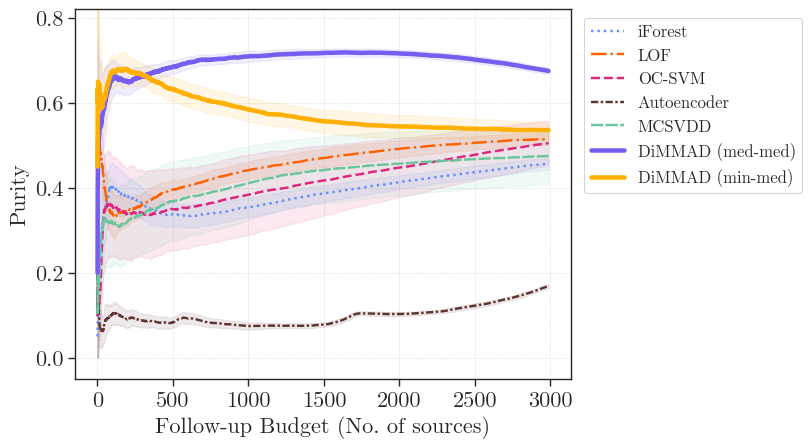


--- Diversity of Discovery Plot ---


Analyzing Models:   0%|          | 0/7 [00:00<?, ?it/s]

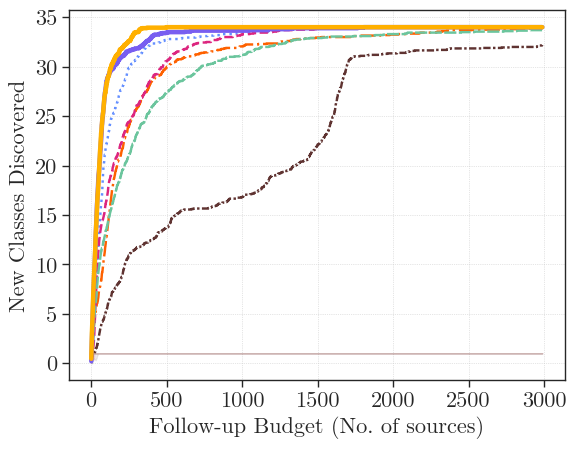

In [37]:
print("\n--- Purity vs. Budget Plot ---")
fig = analysis_with_errors(all_run_results, budget=10000, metric='purity')
plt.ylim(-0.05,0.82)
plt.savefig("06. paper neurips mlps/plots/Exp1_Purity3K.pdf", bbox_inches="tight")
plt.show()

print("\n--- Diversity of Discovery Plot ---")
fig = analysis_with_errors(all_run_results, budget=10000, metric='diversity')
plt.gca().get_legend().remove()
plt.savefig("06. paper neurips mlps/plots/Exp1_Budget3K.pdf", bbox_inches="tight")
plt.show()
